# Twitter Dataset

In this notebook, we apply the back-door adjustment method to a dataset extracted from Twitter. Each user has been annotated with its location (NY or LA) and its gender (Male or Female).

# Table of Contents

1. [Load data from disk][1]
  1. [Download data from Dropbox][2]
  2. [Load data (functions)][3]
  3. [Load data (functions calls)][4]
    1. [Use gender as a confounder][5]
    2. [Use location as a confounder][6]
2. [Experiments][7]
  1. [Load models][8]
  2. [Experiment helper functions][9]
  3. [Predict location with gender as a confounder][10]
    1. [Accuracy experiment][11]
    2. [Export figures][12]
    3. [Simpson's paradox][13]
    4. [Most changing features][14]
    5. [Study effect of C on accuracy][15]
    6. [Top terms table][16]
  4. [Predict gender with location as a confounder][17]
    1. [Accuracy experiment][18]
    2. [Most changing features][19]
    3. [Top terms table][20]
[1]: #Load-data-from-disk
[2]: #Download-data-from-Dropbox
[3]: #Load-data-(functions)
[4]: #Load-data-(functions-calls)
[5]: #Use-gender-as-a-confounder
[6]: #Use-location-as-a-confounder
[7]: #Experiments
[8]: #Load-models
[9]: #Experiment-helper-functions
[10]: #Predict-location-with-gender-as-a-confounder
[11]: #Accuracy-experiment
[12]: #Export-figures
[13]: #Simpson's-paradox
[14]: #Most-changing-features
[15]: #Study-effect-of-C-on-accuracy
[16]: #Top-terms-table
[17]: #Predict-gender-with-location-as-a-confounder
[18]: #Accuracy-experiment
[19]: #Most-changing-features
[20]: #Top-terms-table                                  

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import re
import os.path

from collections import defaultdict, Counter
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

## Load data from disk

### Download data from Dropbox
The process of creating the dataset from 6000 users takes ~2 hours. Therefore, the results have been pickled and can be reloaded in ordered to get the dataset. Our data is [stored on Dropbox](https://www.dropbox.com/sh/pcg731664f8h4fy/AAD9GSey11NGJjgIgXsm5Mw9a/twitter.tgz?dl=1) and its access is protected by a password. If you are interested in using the data for research purposes, please email one of the author to obtain the password. Once you have downloaded and unpacked the data, set the following `DATAPATH` variable to the path where the data is stored.


In [2]:
# set path to the data
DATAPATH = '/Users/ustctll/Desktop/dataset'
TWITTER_PATH = os.path.join(DATAPATH, 'twitter')

### Load data (functions)

In [3]:
class Data(object):
    pass

def load_dataset(users_pkl, term_doc_matrix_pkl, vectorizer_pkl=None, confounder_key='gender',
                 train_ratio=.5, rand=np.random.RandomState(111191)):
    data = Data()
    if vectorizer_pkl is not None:
        print("Loading feature names through vectorizer...")
        with open(vectorizer_pkl, 'rb') as f:
            vec = pickle.load(f)
        data.feature_names = np.array(vec.get_feature_names())[:20]
    print("Loading users pickle...")
    with open(users_pkl, 'rb') as f:
        all_users = pickle.load(f)
    print("Load term document matrix pickle...")
    with open(term_doc_matrix_pkl, 'rb') as f:
        X = pickle.load(f)
    print("Getting label and confounder for every user...")
    Y = []
    C = []
    label_key = 'location' if confounder_key == 'gender' else 'gender'
    for city_users in all_users:
        for u in city_users:
            C.append(u[confounder_key])
            Y.append(u[label_key])
    print("Done")
    print("%d users, %d features" % X.shape)
    C_set = set(C)
    Y_set = set(Y)
    for dc in C_set:
        for dy in Y_set:
            print("\tc = %s and y = %s: %d users" % (dc, dy, len([i for i in range(len(Y)) if Y[i]==dy and C[i]==dc])))
            
    le_C = preprocessing.LabelEncoder()
    le_Y = preprocessing.LabelEncoder()
    C_int = le_C.fit_transform(C)
    Y_int = le_Y.fit_transform(Y)
    print(le_C.classes_)
    print(le_Y.classes_)
    
    indices = list(range(X.shape[0]))
    rand.shuffle(indices)
    train_size = int(train_ratio * X.shape[0])
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]
    data.train_x = X[train_idx,:100]
    data.test_x = X[test_idx,:100]
    data.train_c = C_int[train_idx]
    data.test_c = C_int[test_idx]
    data.train_y = Y_int[train_idx]
    data.test_y = Y_int[test_idx]
    print(data.train_x)
    print(data.train_y)
    print('lengths: x_train %d y_train %d c_train %d' % (data.train_x.shape[0], data.train_y.shape[0], data.train_c.shape[0]))
    print('train y distr', Counter(data.train_y), 'c distr', Counter(data.train_c))
    print('train y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(data.train_y,data.train_c)]))
    
    print('lengths: x_test %d y_test %d c_test %d' % (data.test_x.shape[0], data.test_y.shape[0], data.test_c.shape[0]))
    print('test y distr', Counter(data.test_y), 'c distr', Counter(data.test_c))
    print('test y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(data.test_y,data.test_c)]))
    
    return data

### Load data (functions calls)

#### Use gender as a confounder

In [4]:
data = load_dataset(users_pkl=os.path.join(TWITTER_PATH, "users_array.pkl"),
                    term_doc_matrix_pkl=os.path.join(TWITTER_PATH, "term_doc_matrix.pkl"),
                    vectorizer_pkl=os.path.join(TWITTER_PATH, "vectorizer.pkl"),
                    confounder_key='gender',
                    train_ratio=.5)

Loading feature names through vectorizer...


/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version pre-0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading users pickle...
Load term document matrix pickle...
Getting label and confounder for every user...
Done
6000 users, 21981 features
	c = f and y = la: 1500 users
	c = f and y = ny: 1500 users
	c = m and y = la: 1500 users
	c = m and y = ny: 1500 users
['f' 'm']
['la' 'ny']
  (0, 15)	1
  (0, 88)	1
  (1, 65)	1
  (1, 9)	1
  (1, 5)	1
  (1, 43)	1
  (1, 26)	1
  (1, 87)	1
  (1, 59)	1
  (1, 1)	1
  (1, 75)	1
  (1, 44)	1
  (1, 16)	1
  (2, 86)	1
  (2, 54)	1
  (2, 96)	1
  (2, 91)	1
  (2, 47)	1
  (2, 70)	1
  (2, 99)	1
  (2, 33)	1
  (2, 65)	1
  (2, 56)	1
  (2, 78)	1
  (2, 14)	1
  :	:
  (2997, 6)	1
  (2997, 26)	1
  (2997, 23)	1
  (2997, 87)	1
  (2997, 60)	1
  (2997, 61)	1
  (2997, 48)	1
  (2997, 41)	1
  (2997, 11)	1
  (2997, 69)	1
  (2997, 24)	1
  (2997, 59)	1
  (2997, 1)	1
  (2997, 88)	1
  (2997, 75)	1
  (2997, 42)	1
  (2997, 0)	1
  (2997, 17)	1
  (2997, 44)	1
  (2997, 16)	1
  (2998, 12)	1
  (2998, 88)	1
  (2998, 0)	1
  (2998, 44)	1
  (2999, 16)	1
[1 1 1 ... 1 1 0]
lengths: x_train 3000 y_tra

#### Use location as a confounder

In [5]:
data2 = load_dataset(users_pkl=os.path.join(TWITTER_PATH, "users_array.pkl"),
                    term_doc_matrix_pkl=os.path.join(TWITTER_PATH, "term_doc_matrix.pkl"),
                    vectorizer_pkl=os.path.join(TWITTER_PATH, "vectorizer.pkl"),
                    confounder_key='location',
                    train_ratio=.5)

Loading feature names through vectorizer...


/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version pre-0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading users pickle...
Load term document matrix pickle...
Getting label and confounder for every user...
Done
6000 users, 21981 features
	c = la and y = f: 1500 users
	c = la and y = m: 1500 users
	c = ny and y = f: 1500 users
	c = ny and y = m: 1500 users
['la' 'ny']
['f' 'm']
  (0, 55)	1
  (0, 66)	1
  (0, 86)	1
  (0, 84)	1
  (0, 83)	1
  (0, 96)	1
  (0, 31)	1
  (0, 78)	1
  (0, 81)	1
  (0, 10)	1
  (0, 82)	1
  (0, 12)	1
  (0, 76)	1
  (0, 15)	1
  (0, 43)	1
  (0, 26)	1
  (0, 87)	1
  (0, 13)	1
  (0, 34)	1
  (0, 27)	1
  (0, 7)	1
  (0, 11)	1
  (0, 37)	1
  (0, 69)	1
  (0, 59)	1
  :	:
  (2997, 16)	1
  (2998, 98)	1
  (2998, 68)	1
  (2998, 96)	1
  (2998, 14)	1
  (2998, 10)	1
  (2998, 5)	1
  (2998, 6)	1
  (2998, 60)	1
  (2998, 73)	1
  (2998, 11)	1
  (2998, 59)	1
  (2998, 1)	1
  (2998, 58)	1
  (2998, 88)	1
  (2998, 75)	1
  (2998, 74)	1
  (2998, 44)	1
  (2998, 16)	1
  (2999, 31)	1
  (2999, 56)	1
  (2999, 45)	1
  (2999, 1)	1
  (2999, 44)	1
  (2999, 16)	1
[0 1 0 ... 0 0 0]
lengths: x_train 3000 y_t

## Experiments

### Load models

In [6]:
%run models.py
%run injecting_bias.py
%run confound_plot.py
%run most_changing_coef.py
%run ba_c_study.py

In [7]:
backdoor_adjustment = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,1.,t,u,)
backdoor_adjustment_Z10 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,10,t,u)

### Experiment helper functions

In [8]:
def do_confounding_trials(models, data, ntrials, rand):  
    """ Do several random trials in which we sample data with a confounding variable. 
    Plot the average accuracies as confounding bias increases.
    """
    #test_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    #train_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    test_biases = [.5]
    train_biases = [.5]
#     test_biases = [.1, .5, .9]
#     train_biases = [.1, .5, .9]
    corr_diffs = []
    accuracies = defaultdict(lambda: defaultdict(lambda: []))
    
    for train_bias in train_biases:
        for test_bias in test_biases:
            for ti in range(ntrials):
                # Sample training and testing indices.
                test_idx = make_confounding_data(X=data.test_x, y=data.test_y, c=data.test_c,
                                                pos_prob=.5, bias=test_bias, size=800, rand=rand)  
                test_corr = pearsonr(data.test_y[test_idx], data.test_c[test_idx])[0]
                train_idx = make_confounding_data(X=data.train_x, y=data.train_y, c=data.train_c,
                                                  pos_prob=.5, bias=train_bias, size=800, rand=rand)   
                train_corr = pearsonr(data.train_y[train_idx], data.train_c[train_idx])[0]
                corr_diff = round(train_corr - test_corr, 1)
                if ti == 0:
                    corr_diffs.append(corr_diff)
                    print('train_bias=', train_bias, 'train_corr=', train_corr,
                          'test_bias=', test_bias, 'test_corr=', test_corr,
                          'corr_diff=', corr_diff)
                    
                # Train and test each model.
                for name, model in models:
                    clf = model(data.train_x[train_idx], data.train_y[train_idx],
                                data.train_c[train_idx], rand, data.feature_names)
                    y_pred = clf.predict(data.test_x[test_idx])
                    y_true = data.test_y[test_idx]
                    for y in range(3):
                        for c in range(3):
                            k = 3*y+c
                            cond = lambda x: (c == 2 or data.test_c[x] == c) and (y == 2 or data.test_y[x] == y)
                            yc_test_idx = [i for i, j in enumerate(test_idx) if cond(j)]
                            accuracies[k][name].append({'test_bias': test_bias, 'train_bias': train_bias,
                                                        'corr_diff': corr_diff,
                                                        'acc': accuracy_score(y_true[yc_test_idx],
                                                                              y_pred[yc_test_idx])})
                            print('name',name,'acc',accuracy_score(y_true[yc_test_idx], y_pred[yc_test_idx]))
                        
    return accuracies, corr_diffs, test_biases

In [9]:
def do_confound_expt(data, ntrials=3, models=[('feature_select', feature_select),('logreg', lr),              
                                             ('matching', matching),('backdoor_adjustment', backdoor_adjustment)],
                    confounding_function=do_confounding_trials):                                              
    rand = np.random.RandomState(1234567)                                                                     
    clf = lr(data.train_x, data.train_y, data.train_c, rand, data.feature_names)                              
    print('og testing accuracy=', accuracy_score(data.test_y, clf.predict(data.test_x)))                      
    print('----------------\nExperiments using genre as a confounder:')                                       
    return confounding_function(models, data, ntrials, rand)

### Predict location with gender as a confounder

#### Accuracy experiment

In [10]:
models = [('LR', lr), ('M', matching), ('BA', backdoor_adjustment), ('SO', sumout), ('LRS', lr_subsampling),
          ('BAZ10', backdoor_adjustment_Z10),('CDT',cdtAlg)]
#models = [('CDT',cdtAlg)]
accuracies, corr_diffs, test_biases = do_confound_expt(data, ntrials=1, models=models)

og testing accuracy= 0.518
----------------
Experiments using genre as a confounder:
train_bias= 0.5 train_corr= 0.0 test_bias= 0.5 test_corr= 0.0 corr_diff= 0.0
name LR acc 0.5544554455445545
name LR acc 0.5656565656565656
name LR acc 0.56
name LR acc 0.5
name LR acc 0.4696969696969697
name LR acc 0.485
name LR acc 0.5272277227722773
name LR acc 0.5176767676767676
name LR acc 0.5225
name M acc 0.7376237623762376
name M acc 0.7373737373737373
name M acc 0.7375
name M acc 0.3613861386138614
name M acc 0.3282828282828283
name M acc 0.345
name M acc 0.5495049504950495
name M acc 0.5328282828282829
name M acc 0.54125
name BA acc 0.5643564356435643
name BA acc 0.5656565656565656
name BA acc 0.565
name BA acc 0.504950495049505
name BA acc 0.47474747474747475
name BA acc 0.49
name BA acc 0.5346534653465347
name BA acc 0.5202020202020202
name BA acc 0.5275
name SO acc 0.5693069306930693
name SO acc 0.5555555555555556
name SO acc 0.5625
name SO acc 0.5198019801980198
name SO acc 0.4949494949494

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

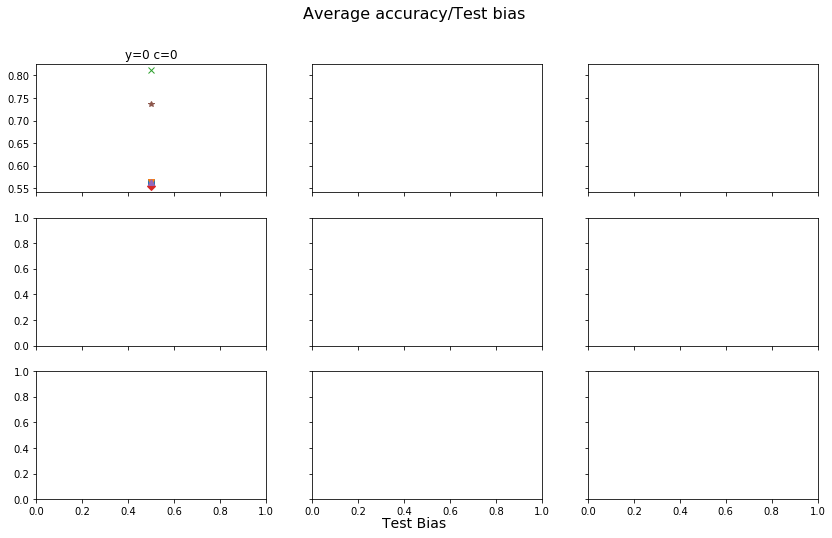

In [11]:
test_bias_axis = (test_biases, 'test_bias', 'Test Bias')
corr_diff_axis = (corr_diffs, 'corr_diff', 'correlation difference (train-test)')

to_plot = ['logistic regression']
plot_all_accuracies(accuracies, test_bias_axis, title='Average accuracy/Test bias', xlim=[0,1])#, keys=to_plot)
plot_all_accuracies(accuracies, corr_diff_axis, title='Accuracy/Correlation difference')#, keys=to_plot)

In [ ]:
for y in range(3):
    for c in range(3):
        plot_accuracy(accuracies, test_bias_axis, y=y, c=c, xlim=[0,1])
        plot_accuracy(accuracies, corr_diff_axis, y=y, c=c)

#### Export figures

In [ ]:
for tr_bias in np.arange(0.1, 1., 0.1):
    ylabel="Accuracy for train bias=%.1f" % tr_bias
    export_plot_accuracy('test', accuracies, test_bias_axis, 2, 2, title='', xlabel='Test bias', train_bias=tr_bias,
                         ylabel=ylabel, xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1))

In [ ]:
toplot = ['BA', 'BAZ10', 'LR', 'M', 'LRS']

# Export IMDb plots
fig = export_plot_accuracy('../paper/figures/twitter_accuracy_corr_diff.pdf',
                           accuracies, corr_diff_axis, 2, 2, title='',
                           xlabel='Correlation difference (train-test)', ncol=3,
                           ylabel='Accuracy')

fig = export_plot_accuracy('../paper/figures/twitter_accuracy_test_bias.pdf',
                           accuracies, test_bias_axis, 2, 2, title='', ncol=3,
                           xlabel='Test bias',
                           ylabel='Accuracy averaged over the training biases', xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1))

#### Simpson's paradox

In [ ]:
%run simpson_paradox.py

In [ ]:
methods = [('BAZ10', backdoor_adjustment_Z10), ('LR', lr), ('LRS', lr_subsampling), ('BA', backdoor_adjustment)]
rand = np.random.RandomState(111191)
biases, spa_count_bias_results = simpson_paradox_count_bias(data, methods, 800, rand=rand)

In [ ]:
markers = {
    'BAZ10': 'gv-',
    'LR': 'rx-',
    'BA': 'bs-',
    'LRS': 'cD-'
}
plot_spa_results(biases, spa_count_bias_results, markers, tofile="../paper/figures/simpson_paradox_expt.pdf", n_fts=21981.)

#### Most changing features

In [ ]:
%run most_changing_coef.py

In [ ]:
params = dict(data=data,
              n=30,
              models=[(backdoor_adjustment, 'BA', 'bs'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Los Angeles', 'New York'],
              feature_names=np.hstack([data.feature_names, ['c=0', 'c=1']]))
changing_coef_plot(**params)

In [ ]:
%run most_changing_coef.py

In [ ]:
x2, pval = chi2(data.train_x, data.train_c)
top_ft_idx = np.argsort(x2)[::-1][:10][::-1]
params = dict(data=data,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment, 'BA', 'bs'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.9],
              size=800,
              trials=2,
              class_labels=['Los Angeles', 'New York'],
              indices=top_ft_idx)
changing_coef_plot_given_idx(**params)

In [ ]:
x2, pval = chi2(data.train_x, data.train_y)
top_ft_idx = np.argsort(x2)[::-1][:10][::-1]
params = dict(data=data,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment, 'BA', 'bs'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.9],
              size=800,
              trials=2,
              class_labels=['Los Angeles', 'New York'],
              indices=top_ft_idx)
changing_coef_plot_given_idx(**params)

#### Study effect of C on accuracy

In [ ]:
c_range = np.logspace(-3, 4, 15)
methods = [('BA', backdoor_adjustment_var_C)]
filter_corr_diff = lambda x: np.abs(x) > 1.2
accuracies_c, coefs_c = do_c_study(c_range, filter_corr_diff, data, 5,
                                   np.random.RandomState(111191), 800, 5)

In [ ]:
plot_c_study(c_range, accuracies_c, coefs_c, tofile='../paper/figures/ba_c_study.pdf')

#### Top terms table

In [ ]:
%run top_terms_table.py

In [ ]:
do_top_coef_table(data, lr, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)

In [ ]:
do_top_coef_table(data, backdoor_adjustment, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)

In [ ]:
do_top_coef_table(data, backdoor_adjustment_Z10, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)

### Predict gender with location as a confounder

#### Accuracy experiment

In [ ]:
models = [('LR', lr), ('M', matching), ('BA', backdoor_adjustment), ('SO', sumout), ('LRS', lr_subsampling),
          ('BAZ10', backdoor_adjustment_Z10)]
accuracies2, corr_diffs2, test_biases2 = do_confound_expt(data2, ntrials=5, models=models)

In [ ]:
test_bias_axis2 = (test_biases2, 'test_bias', 'Test Bias')
corr_diff_axis2 = (corr_diffs2, 'corr_diff', 'correlation difference (train-test)')

plot_all_accuracies(accuracies2, test_bias_axis2, title='Average accuracy/Test bias', xlim=[0,1])#, keys=to_plot)
plot_all_accuracies(accuracies2, corr_diff_axis2, title='Accuracy/Correlation difference')#, keys=to_plot)

In [ ]:
for y in range(3):
    for c in range(3):
        plot_accuracy(accuracies2, test_bias_axis2, y=y, c=c, xlim=[0,1])#, keys=['lr subsampling', 'backdoor adjustment'])
        plot_accuracy(accuracies2, corr_diff_axis2, y=y, c=c)#, keys=['lr subsampling', 'backdoor adjustment'])

#### Most changing features

In [ ]:
%run most_changing_coef.py

In [ ]:
params = dict(data=data2,
              n=30,
              models=[(backdoor_adjustment, 'BA', 'bs'),(backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Female', 'Male'],
              feature_names=np.hstack([data.feature_names, ['c=0', 'c=1']]))
changing_coef_plot(**params)

In [ ]:
params = dict(data=data2,
              n=60,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Female', 'Male'])
changing_coef_plot(**params)

#### Top terms table

In [ ]:
%run top_terms_table.py

In [ ]:
do_top_coef_table(data2, lr, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)

In [ ]:
do_top_coef_table(data2, backdoor_adjustment, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)

In [ ]:
do_top_coef_table(data2, backdoor_adjustment_Z10, 5, 800, 10, np.random.RandomState(111191), 1., data.feature_names)